In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib
from DataPreprocess import DataProcessing
from CNNModel import Model

In [3]:
# Define the downsampling mechanism for build label-uniformed training data/label.

def samp(trainData, trainLabel):
    data, label = shuffle(trainData, trainLabel)
    labelNum1 = int(np.sum(trainLabel))
    labelNum0 = labelNum1 + np.random.randint(-labelNum1 * 0.01, labelNum1 * 0.01)
    labelNum = labelNum1 + labelNum0
    Data = np.zeros((labelNum, 50, 50, 3), dtype = np.float32)
    Label = np.zeros((labelNum, ), dtype = np.float32)
    count = 0
    indexCount = 0
    for i in range(data.shape[0]):
        if indexCount > labelNum:
            break
        if label[i] == 1:
            Data[indexCount, :, :, :] = data[i, :, :, :]
            Label[indexCount] = label[i]
            indexCount += 1
        else:
            if count < labelNum0: 
                Data[indexCount, :, :, :] = data[i, :, :, :]
                Label[indexCount] = label[i]
                count += 1
                indexCount += 1
    resData, resLabel = shuffle(Data, Label)
    return resData, resLabel
    
def shuffle(data, label):
    #
    # Shuffle the input data and correspond label.
    #
    shapeNum = data.shape[0]
    indexList = np.arange(0, shapeNum)
    np.random.shuffle(indexList)
    Data = data[indexList]
    Label = label[indexList]

    return Data, Label

In [4]:
# Prepared the training and testing data/label;
sample = DataProcessing(mode='biase')
sample.prepareTrainData()

# Read the training data/label and testing data/label;
trainData, trainLabel = sample.readDataLabel(mode = 'train')
testData, testLabel = sample.readDataLabel(mode = 'test')

# Transform the training data/label from biased to un-biased based on downsampling mechanism.
trainData, trainLabel = samp(trainData, trainLabel)

C:\Users\Yonghao Zhou\jupyter_notebook\DataPreprocess.py:252: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  Data = hFile.get('trainData').value
C:\Users\Yonghao Zhou\jupyter_notebook\DataPreprocess.py:253: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  Label = hFile.get('trainLabel').value
C:\Users\Yonghao Zhou\jupyter_notebook\DataPreprocess.py:257: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  Data = hFile.get('testData').value
C:\Users\Yonghao Zhou\jupyter_notebook\DataPreprocess.py:258: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  Label = hFile.get('testLabel').value


In [5]:
# unbiased with down-sampling.
model = Model()
model.train(trainData, trainLabel, testData, testLabel) # Train the model with 20 epochs.

Epoch 1/20
1097/1097 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.7875
Epoch 00001: val_accuracy improved from -inf to 0.84223, saving model to model_unbiased.h5
1097/1097 [==============================] - 7s 6ms/step - loss: 0.4642 - accuracy: 0.7875 - val_loss: 0.3900 - val_accuracy: 0.8422
Epoch 2/20
1095/1097 [============================>.] - ETA: 0s - loss: 0.4140 - accuracy: 0.8180
Epoch 00002: val_accuracy improved from 0.84223 to 0.85003, saving model to model_unbiased.h5
1097/1097 [==============================] - 7s 6ms/step - loss: 0.4139 - accuracy: 0.8180 - val_loss: 0.3600 - val_accuracy: 0.8500
Epoch 3/20
1091/1097 [============================>.] - ETA: 0s - loss: 0.4006 - accuracy: 0.8260
Epoch 00003: val_accuracy did not improve from 0.85003
1097/1097 [==============================] - 6s 5ms/step - loss: 0.4006 - accuracy: 0.8260 - val_loss: 0.3714 - val_accuracy: 0.8388
Epoch 4/20
1095/1097 [============================>.] - ETA: 0s - l

In [6]:
# load the trained model.
from tensorflow.python.keras.models import load_model
model = load_model("model_biased.h5")

In [7]:
# Read the training data/label and testing data/label;
trainData, trainLabel = sample.readDataLabel(mode = 'train')
testData, testLabel = sample.readDataLabel(mode = 'test')
label_trainHot = tf.keras.utils.to_categorical(trainLabel, num_classes = 2)
label_testHot = tf.keras.utils.to_categorical(testLabel, num_classes = 2)

# Continue the model training and record the trained model with maximum predicting accuracy in testing dataset.
save_best_model = ModelCheckpoint('model_biased.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
cnn_model = model.fit(trainData, label_trainHot, validation_data=(testData, label_testHot), epochs=20, batch_size=256, callbacks=[save_best_model])

Epoch 1/20
963/963 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8754
Epoch 00001: val_accuracy improved from -inf to 0.89195, saving model to model_biased.h5
963/963 [==============================] - 9s 9ms/step - loss: 0.2949 - accuracy: 0.8754 - val_loss: 0.2629 - val_accuracy: 0.8920
Epoch 2/20
961/963 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8758
Epoch 00002: val_accuracy did not improve from 0.89195
963/963 [==============================] - 9s 9ms/step - loss: 0.2943 - accuracy: 0.8758 - val_loss: 0.2813 - val_accuracy: 0.8868
Epoch 3/20
960/963 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8770
Epoch 00003: val_accuracy did not improve from 0.89195
963/963 [==============================] - 9s 9ms/step - loss: 0.2909 - accuracy: 0.8770 - val_loss: 0.2817 - val_accuracy: 0.8832
Epoch 4/20
962/963 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8776
Epoch 00004: val_accurac

The testing result could be shown as:

The average mAP value is 0.5817, the average accuracy is 86.59%
The stdev of mAP value is 0.2352, the stdev of accuracy is 7.38%


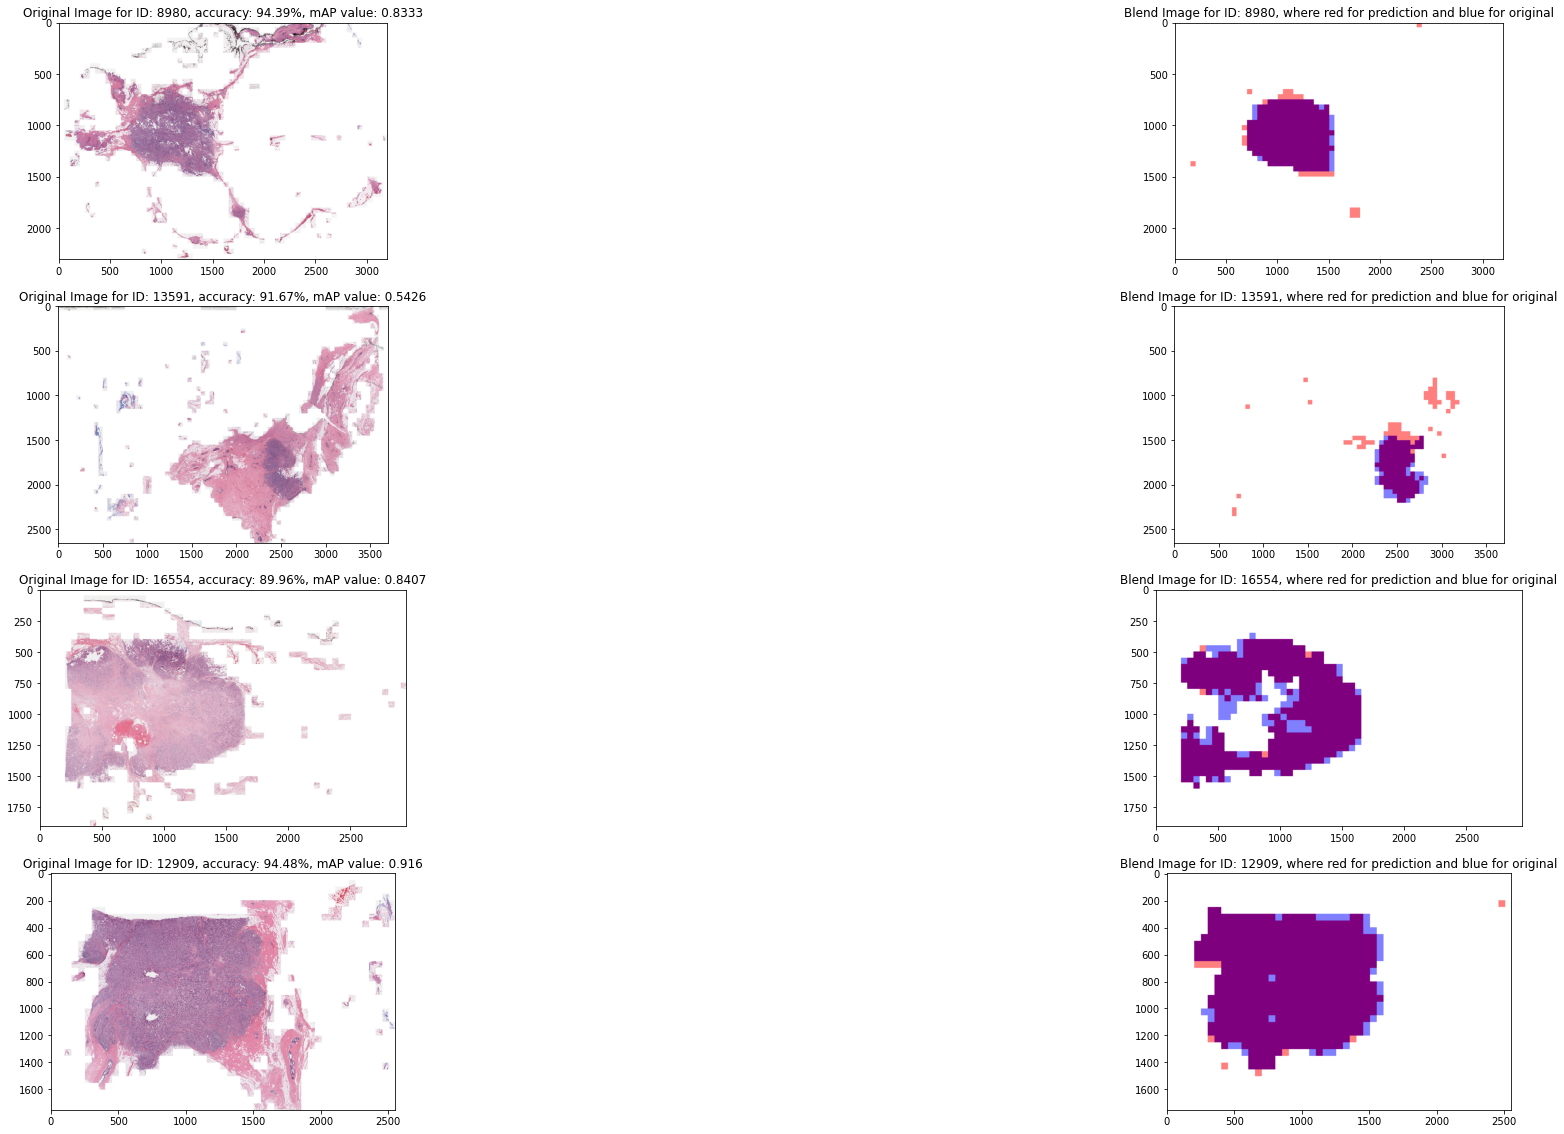

In [8]:
# Test with unibased model under down-sampling mechanism and show 4 testing cases.
sample.Test(modelAddress = os.path.join(os.getcwd(), 'model_unbiased_downsample.h5'), numShow=4) # Test the model and plot result for 4 patent ID.

The testing result could be shown as:

The average mAP value is 0.6102, the average accuracy is 88.86%
The stdev of mAP value is 0.2204, the stdev of accuracy is 6.72%


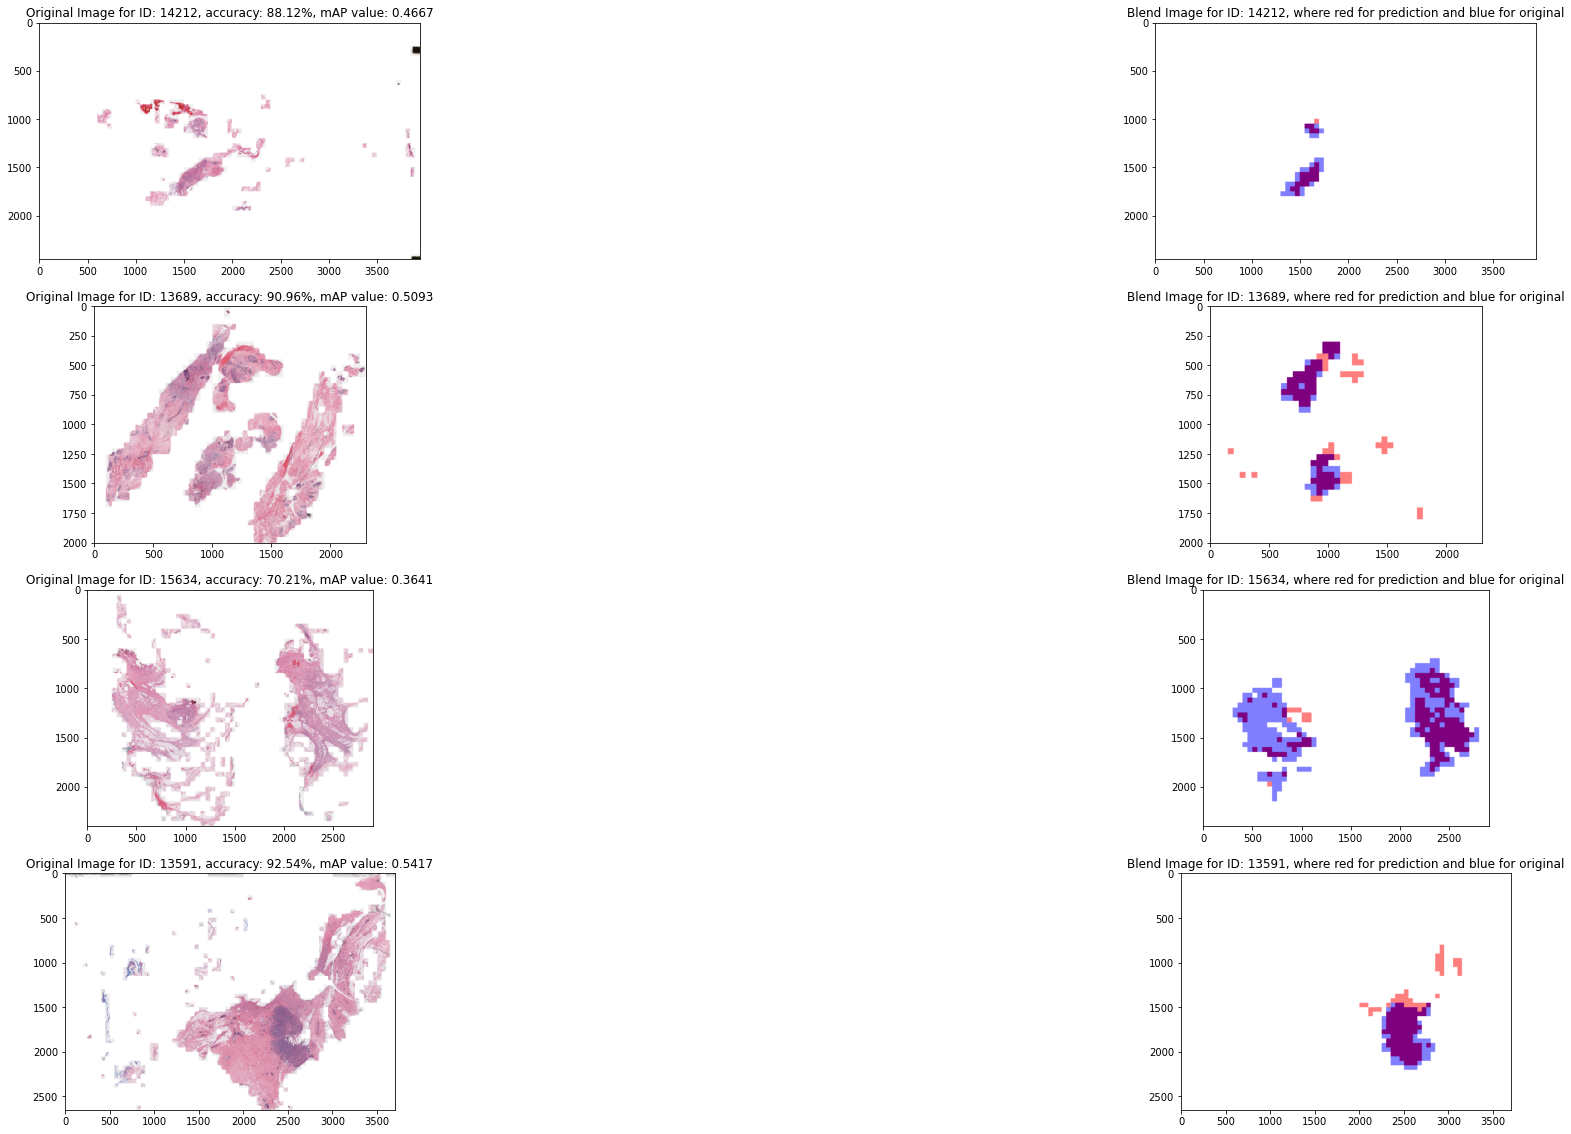

In [9]:
# Test with unibased model under biased dataset(original data from data folder only) and show 4 testing cases.
sample.Test(modelAddress = os.path.join(os.getcwd(), 'model_biased.h5'), numShow=4) # Test the model and plot result for 4 patent ID.